In [12]:
# ============================================================================
# CELL 1: Setup and Environment Check
# ============================================================================
import os, random, time
import torch
print("PyTorch version:", torch.__version__)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    device = torch.device("cuda")
else:
    print("No GPU available")
    device = torch.device("cpu")

# Reproducibility
SEED = 42
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
import numpy as np
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

!pip install --upgrade pip --quiet
!pip install pandas scikit-learn matplotlib seaborn tqdm --quiet

PyTorch version: 2.8.0+cu126
GPU: Tesla T4


In [13]:
# ============================================================================
# CELL 2: Upload and Unzip Dataset
# ============================================================================
import glob
import pandas as pd
from google.colab import files

# Upload the archive.zip file from your computer
print("Please upload your archive.zip file...")
uploaded = files.upload()

# Get the uploaded filename (should be archive.zip)
zip_path = list(uploaded.keys())[0]
print(f"\n✓ Uploaded: {zip_path}")

# Make sure the dataset folder exists fresh
if os.path.exists("dataset"):
    !rm -rf dataset

# Unzip archive
!unzip -o "{zip_path}" -d dataset

# List all CSV files to confirm
csv_files = glob.glob("dataset/**/*.csv", recursive=True)
print(f"\nNumber of CSV files found: {len(csv_files)}")

if len(csv_files) == 0:
    print("\n⚠️ No CSV files found! Checking directory structure...")
    !ls -la dataset/
    # Maybe files are directly in dataset folder, not in subdirectory
    csv_files = glob.glob("dataset/*.csv", recursive=False)
    print(f"CSV files in dataset/: {len(csv_files)}")

print(f"\nFirst 10 files:")
for f in csv_files[:10]:
    print(f"  {f}")

# ============================================================================
# INSPECT CSV STRUCTURE
# ============================================================================
if len(csv_files) > 0:
    print("\n" + "="*60)
    print("INSPECTING CSV FILE STRUCTURE")
    print("="*60)

    # Check first 3 CSV files to understand structure
    for i, csv_file in enumerate(csv_files[:3]):
        print(f"\n--- File {i+1}: {os.path.basename(csv_file)} ---")
        try:
            df_sample = pd.read_csv(csv_file)
            print(f"Shape: {df_sample.shape}")
            print(f"Columns: {df_sample.columns.tolist()}")
            print(f"First row preview:")
            print(df_sample.head(1).to_string())
        except Exception as e:
            print(f"Error reading file: {e}")
else:
    print("\n❌ ERROR: No CSV files found after unzipping!")
    print("Please check your archive.zip file structure.")

Please upload your archive.zip file...


Saving archive.zip to archive.zip

✓ Uploaded: archive.zip
Archive:  archive.zip
  inflating: dataset/absence-of-certain-changes-or-events.csv  
  inflating: dataset/absence-of-certain-changes.csv  
  inflating: dataset/acceleration.csv  
  inflating: dataset/access-to-information.csv  
  inflating: dataset/access.csv      
  inflating: dataset/accounting-terms.csv  
  inflating: dataset/additional-agreements.csv  
  inflating: dataset/additional-documents.csv  
  inflating: dataset/adjustments.csv  
  inflating: dataset/affirmative-covenants.csv  
  inflating: dataset/agreement.csv   
  inflating: dataset/agreements.csv  
  inflating: dataset/amendment-and-waiver.csv  
  inflating: dataset/amendment-waiver.csv  
  inflating: dataset/amendment.csv   
  inflating: dataset/amendments-and-waivers.csv  
  inflating: dataset/amendments-etc.csv  
  inflating: dataset/amendments-waivers.csv  
  inflating: dataset/amendments.csv  
  inflating: dataset/applicable-law.csv  
  inflating: dataset/

In [14]:
# ============================================================================
# CELL 3: Data Loading and Preprocessing Class (FIXED)
# ============================================================================
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import Counter
import re

class LegalClauseDataProcessor:
    """Processes legal clause data and creates similarity pairs"""

    def __init__(self, csv_files, max_vocab_size=10000):
        self.csv_files = csv_files
        self.max_vocab_size = max_vocab_size
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        self.idx2word = {0: "<PAD>", 1: "<UNK>"}
        self.max_len = 100

    def clean_text(self, text):
        """Clean and normalize legal text"""
        if not isinstance(text, str):
            return ""
        if len(text.strip()) == 0:
            return ""
        text = text.lower()
        text = re.sub(r'[^a-z0-9\s]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def load_all_clauses(self):
        """Load all clauses from CSV files"""
        all_clauses = []

        for file_idx, file in enumerate(self.csv_files):
            try:
                # Get category name from filename
                category = os.path.basename(file).replace('.csv', '')

                # Read CSV
                df = pd.read_csv(file)

                # Skip if empty
                if df.empty:
                    print(f"Skipping empty file: {category}")
                    continue

                # DEBUG: Show structure of first few files
                if file_idx < 3:
                    print(f"\n[DEBUG] File: {category}")
                    print(f"  Columns: {df.columns.tolist()}")
                    print(f"  Shape: {df.shape}")

                # Find the text column - try multiple strategies
                text_col = None

                # Strategy 1: Look for common text column names
                for col in df.columns:
                    col_lower = str(col).lower().strip()
                    if any(keyword in col_lower for keyword in ['text', 'clause', 'content', 'description', 'provision']):
                        text_col = col
                        break

                # Strategy 2: If only 1 column, use it
                if text_col is None and len(df.columns) == 1:
                    text_col = df.columns[0]

                # Strategy 3: Use the column with longest average text
                if text_col is None:
                    avg_lengths = {}
                    for col in df.columns:
                        try:
                            avg_lengths[col] = df[col].astype(str).str.len().mean()
                        except:
                            avg_lengths[col] = 0
                    text_col = max(avg_lengths, key=avg_lengths.get)

                if file_idx < 3:
                    print(f"  Using column: '{text_col}'")

                # Extract clauses from the identified column
                loaded_count = 0
                for _, row in df.iterrows():
                    try:
                        clause_text = row[text_col]

                        # Skip invalid entries
                        if pd.isna(clause_text):
                            continue

                        # Convert to string and clean
                        clause_text = str(clause_text).strip()

                        # Skip if too short (likely not a real clause)
                        if len(clause_text) < 10:
                            continue

                        cleaned_text = self.clean_text(clause_text)

                        # Only add if cleaning produced valid text
                        if len(cleaned_text) > 5:  # At least a few words
                            all_clauses.append({
                                'text': cleaned_text,
                                'category': category
                            })
                            loaded_count += 1

                    except Exception as e:
                        continue

                if file_idx < 5 or loaded_count > 0:
                    print(f"  ✓ Loaded {loaded_count} clauses from {category}")

            except Exception as e:
                print(f"  ✗ Error loading {os.path.basename(file)}: {e}")
                continue

        # Check if we loaded anything
        if len(all_clauses) == 0:
            print("\n" + "="*60)
            print("ERROR: No clauses loaded!")
            print("="*60)
            print("Please check:")
            print("1. Are the CSV files in the correct format?")
            print("2. Do they contain text data?")
            print("3. Run Cell 2 again to inspect the file structure")
            raise ValueError("No clauses loaded! Check your CSV file structure.")

        df_result = pd.DataFrame(all_clauses)
        print(f"\n{'='*60}")
        print(f"✓ SUCCESSFULLY LOADED: {len(df_result)} total clauses")
        print(f"✓ Categories: {df_result['category'].nunique()}")
        print(f"{'='*60}")

        return df_result

    def build_vocabulary(self, texts):
        """Build vocabulary from texts"""
        word_freq = Counter()
        for text in texts:
            words = text.split()
            word_freq.update(words)

        # Get most common words
        most_common = word_freq.most_common(self.max_vocab_size - 2)

        for idx, (word, _) in enumerate(most_common, start=2):
            self.word2idx[word] = idx
            self.idx2word[idx] = word

        print(f"Vocabulary size: {len(self.word2idx)}")
        return self.word2idx

    def text_to_sequence(self, text):
        """Convert text to sequence of indices"""
        words = text.split()[:self.max_len]
        sequence = [self.word2idx.get(word, 1) for word in words]
        # Pad sequence
        if len(sequence) < self.max_len:
            sequence += [0] * (self.max_len - len(sequence))
        return sequence

    def create_similarity_pairs(self, df, num_positive=3000, num_negative=3000):
        """Create positive and negative pairs for training"""
        pairs = []
        labels = []

        print("\nCreating similarity pairs...")

        # Positive pairs (same category)
        grouped = df.groupby('category')
        pos_per_category = max(1, num_positive // len(grouped))

        for category, group in grouped:
            clauses = group['text'].tolist()
            if len(clauses) < 2:
                print(f"  Skipping {category} (only {len(clauses)} clause)")
                continue

            count = 0
            for i in range(len(clauses)):
                for j in range(i + 1, len(clauses)):
                    if count >= pos_per_category:
                        break
                    pairs.append((clauses[i], clauses[j]))
                    labels.append(1)
                    count += 1
                if count >= pos_per_category:
                    break

        print(f"  Created {sum(labels)} positive pairs")

        # Negative pairs (different categories)
        categories = df['category'].unique()
        if len(categories) < 2:
            print("  Warning: Only one category found, creating random negative pairs")
            all_clauses = df['text'].tolist()
            for _ in range(num_negative):
                idx1, idx2 = np.random.choice(len(all_clauses), 2, replace=False)
                pairs.append((all_clauses[idx1], all_clauses[idx2]))
                labels.append(0)
        else:
            for _ in range(num_negative):
                cat1, cat2 = np.random.choice(categories, 2, replace=False)
                clause1 = df[df['category'] == cat1].sample(1)['text'].iloc[0]
                clause2 = df[df['category'] == cat2].sample(1)['text'].iloc[0]
                pairs.append((clause1, clause2))
                labels.append(0)

        print(f"  Created {len(labels) - sum(labels)} negative pairs")
        print(f"  Total: {len(pairs)} pairs (Balance: {sum(labels)/len(labels)*100:.1f}% positive)")

        return pairs, labels

# Initialize processor and load data
print("\n" + "="*60)
print("LOADING AND PROCESSING DATA")
print("="*60)

processor = LegalClauseDataProcessor(csv_files)
df = processor.load_all_clauses()

# Show statistics
print(f"\nDataset Statistics:")
print(f"  Total clauses: {len(df)}")
print(f"  Unique categories: {df['category'].nunique()}")
print(f"  Avg clause length: {df['text'].str.len().mean():.0f} characters")
print(f"\nTop 5 categories by count:")
print(df['category'].value_counts().head())
print(f"\nSample clause:\n  {df['text'].iloc[0][:200]}...")


LOADING AND PROCESSING DATA

[DEBUG] File: delivery
  Columns: ['clause_text', 'clause_type']
  Shape: (410, 2)
  Using column: 'clause_text'
  ✓ Loaded 410 clauses from delivery

[DEBUG] File: captions
  Columns: ['clause_text', 'clause_type']
  Shape: (580, 2)
  Using column: 'clause_text'
  ✓ Loaded 580 clauses from captions

[DEBUG] File: conditions-to-effectiveness
  Columns: ['clause_text', 'clause_type']
  Shape: (530, 2)
  Using column: 'clause_text'
  ✓ Loaded 530 clauses from conditions-to-effectiveness
  ✓ Loaded 330 clauses from limitation-on-liability
  ✓ Loaded 350 clauses from title
  ✓ Loaded 300 clauses from notices
  ✓ Loaded 380 clauses from entire-agreement-amendment
  ✓ Loaded 470 clauses from additional-documents
  ✓ Loaded 290 clauses from effect-of-headings
  ✓ Loaded 310 clauses from employees
  ✓ Loaded 279 clauses from witnesseth-that
  ✓ Loaded 360 clauses from voting
  ✓ Loaded 380 clauses from amendment-waiver
  ✓ Loaded 330 clauses from usa-patriot-act
 

In [15]:
# ============================================================================
# CELL 4: Create Dataset and DataLoader
# ============================================================================
class ClausePairDataset(Dataset):
    """Dataset for clause similarity pairs"""

    def __init__(self, pairs, labels, processor):
        self.pairs = pairs
        self.labels = labels
        self.processor = processor

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        clause1, clause2 = self.pairs[idx]
        label = self.labels[idx]

        seq1 = self.processor.text_to_sequence(clause1)
        seq2 = self.processor.text_to_sequence(clause2)

        return {
            'clause1': torch.LongTensor(seq1),
            'clause2': torch.LongTensor(seq2),
            'label': torch.FloatTensor([label])
        }

# Build vocabulary and create pairs
processor.build_vocabulary(df['text'].tolist())
pairs, labels = processor.create_similarity_pairs(df)

# Split data
train_pairs, temp_pairs, train_labels, temp_labels = train_test_split(
    pairs, labels, test_size=0.3, random_state=SEED, stratify=labels
)
val_pairs, test_pairs, val_labels, test_labels = train_test_split(
    temp_pairs, temp_labels, test_size=0.5, random_state=SEED, stratify=temp_labels
)

print(f"Train: {len(train_pairs)}, Val: {len(val_pairs)}, Test: {len(test_pairs)}")

# Create datasets
train_dataset = ClausePairDataset(train_pairs, train_labels, processor)
val_dataset = ClausePairDataset(val_pairs, val_labels, processor)
test_dataset = ClausePairDataset(test_pairs, test_labels, processor)

# Create dataloaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


Vocabulary size: 10000

Creating similarity pairs...
  Created 2765 positive pairs
  Created 3000 negative pairs
  Total: 5765 pairs (Balance: 48.0% positive)
Train: 4035, Val: 865, Test: 865


In [16]:
# ============================================================================
# CELL 5: Model 1 - BiLSTM-based Similarity Model
# ============================================================================
import torch.nn as nn

class BiLSTMSimilarity(nn.Module):
    """BiLSTM-based model for clause similarity"""

    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=64, num_layers=2):
        super(BiLSTMSimilarity, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_dim, num_layers,
            bidirectional=True, batch_first=True, dropout=0.3
        )
        self.dropout = nn.Dropout(0.3)

        # Similarity computation layers
        self.fc1 = nn.Linear(hidden_dim * 4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        """Encode clause using BiLSTM"""
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        # Use last hidden state from both directions
        forward_hidden = hidden[-2, :, :]
        backward_hidden = hidden[-1, :, :]
        encoding = torch.cat([forward_hidden, backward_hidden], dim=1)
        return encoding

    def forward(self, clause1, clause2):
        """Compute similarity between two clauses"""
        enc1 = self.encode(clause1)
        enc2 = self.encode(clause2)

        # Concatenate encodings
        combined = torch.cat([enc1, enc2], dim=1)
        combined = self.dropout(combined)

        # Pass through dense layers
        x = self.relu(self.fc1(combined))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc3(x))

        return x

# Initialize model
vocab_size = len(processor.word2idx)
model_bilstm = BiLSTMSimilarity(vocab_size).to(device)
print(f"BiLSTM Model Parameters: {sum(p.numel() for p in model_bilstm.parameters())}")


BiLSTM Model Parameters: 1519873


In [17]:
# ============================================================================
# CELL 6: Model 2 - Attention-based Encoder Model
# ============================================================================
class AttentionEncoder(nn.Module):
    """Attention-based encoder for clause similarity"""

    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=64):
        super(AttentionEncoder, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)

        # Self-attention mechanism
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.dropout = nn.Dropout(0.3)

        # Similarity layers
        self.fc1 = nn.Linear(hidden_dim * 4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode_with_attention(self, x):
        """Encode with self-attention"""
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)

        # Compute attention weights
        attention_scores = self.attention(lstm_out)
        attention_weights = torch.softmax(attention_scores, dim=1)

        # Apply attention
        attended = torch.sum(attention_weights * lstm_out, dim=1)
        return attended

    def forward(self, clause1, clause2):
        """Compute similarity with attention"""
        enc1 = self.encode_with_attention(clause1)
        enc2 = self.encode_with_attention(clause2)

        # Combine encodings
        combined = torch.cat([enc1, enc2], dim=1)
        combined = self.dropout(combined)

        # Pass through dense layers
        x = self.relu(self.fc1(combined))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc3(x))

        return x

# Initialize attention model
model_attention = AttentionEncoder(vocab_size).to(device)
print(f"Attention Model Parameters: {sum(p.numel() for p in model_attention.parameters())}")


Attention Model Parameters: 1420674


In [18]:
# ============================================================================
# CELL 7: Training and Evaluation Functions
# ============================================================================
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tqdm import tqdm

class ModelTrainer:
    """Trainer class for model training and evaluation"""

    def __init__(self, model, device, model_name="Model"):
        self.model = model
        self.device = device
        self.model_name = model_name
        self.history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    def train_epoch(self, train_loader, criterion, optimizer):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0
        all_preds = []
        all_labels = []

        for batch in tqdm(train_loader, desc=f"Training {self.model_name}"):
            clause1 = batch['clause1'].to(self.device)
            clause2 = batch['clause2'].to(self.device)
            labels = batch['label'].to(self.device)

            optimizer.zero_grad()
            outputs = self.model(clause1, clause2)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = (outputs > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        avg_loss = total_loss / len(train_loader)
        accuracy = accuracy_score(all_labels, all_preds)
        return avg_loss, accuracy

    def evaluate(self, loader, criterion):
        """Evaluate model"""
        self.model.eval()
        total_loss = 0
        all_preds = []
        all_probs = []
        all_labels = []

        with torch.no_grad():
            for batch in loader:
                clause1 = batch['clause1'].to(self.device)
                clause2 = batch['clause2'].to(self.device)
                labels = batch['label'].to(self.device)

                outputs = self.model(clause1, clause2)
                loss = criterion(outputs, labels)

                total_loss += loss.item()
                preds = (outputs > 0.5).float()
                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(outputs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_loss = total_loss / len(loader)
        accuracy = accuracy_score(all_labels, all_preds)
        return avg_loss, accuracy, all_preds, all_probs, all_labels

    def train(self, train_loader, val_loader, epochs=10, lr=0.001):
        """Full training loop"""
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

        start_time = time.time()

        for epoch in range(epochs):
            train_loss, train_acc = self.train_epoch(train_loader, criterion, optimizer)
            val_loss, val_acc, _, _, _ = self.evaluate(val_loader, criterion)

            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)

            print(f"Epoch {epoch+1}/{epochs}")
            print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
            print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        training_time = time.time() - start_time
        print(f"\nTotal training time: {training_time:.2f}s")
        return self.history, training_time


In [19]:
# ============================================================================
# CELL 8: Train BiLSTM Model
# ============================================================================
print("="*60)
print("TRAINING BiLSTM MODEL")
print("="*60)

trainer_bilstm = ModelTrainer(model_bilstm, device, "BiLSTM")
history_bilstm, time_bilstm = trainer_bilstm.train(train_loader, val_loader, epochs=10, lr=0.001)


TRAINING BiLSTM MODEL


Training BiLSTM: 100%|██████████| 127/127 [00:02<00:00, 45.42it/s]


Epoch 1/10
  Train Loss: 0.6867, Train Acc: 0.5388
  Val Loss: 0.6552, Val Acc: 0.5931


Training BiLSTM: 100%|██████████| 127/127 [00:01<00:00, 108.48it/s]


Epoch 2/10
  Train Loss: 0.5728, Train Acc: 0.6810
  Val Loss: 0.5204, Val Acc: 0.7410


Training BiLSTM: 100%|██████████| 127/127 [00:01<00:00, 109.07it/s]


Epoch 3/10
  Train Loss: 0.3743, Train Acc: 0.8354
  Val Loss: 0.3866, Val Acc: 0.8266


Training BiLSTM: 100%|██████████| 127/127 [00:01<00:00, 106.25it/s]


Epoch 4/10
  Train Loss: 0.1862, Train Acc: 0.9328
  Val Loss: 0.2607, Val Acc: 0.9110


Training BiLSTM: 100%|██████████| 127/127 [00:01<00:00, 107.53it/s]


Epoch 5/10
  Train Loss: 0.1029, Train Acc: 0.9660
  Val Loss: 0.2065, Val Acc: 0.9410


Training BiLSTM: 100%|██████████| 127/127 [00:01<00:00, 107.24it/s]


Epoch 6/10
  Train Loss: 0.0587, Train Acc: 0.9792
  Val Loss: 0.3068, Val Acc: 0.9306


Training BiLSTM: 100%|██████████| 127/127 [00:01<00:00, 106.97it/s]


Epoch 7/10
  Train Loss: 0.0430, Train Acc: 0.9844
  Val Loss: 0.1789, Val Acc: 0.9503


Training BiLSTM: 100%|██████████| 127/127 [00:01<00:00, 106.91it/s]


Epoch 8/10
  Train Loss: 0.0312, Train Acc: 0.9891
  Val Loss: 0.3320, Val Acc: 0.9260


Training BiLSTM: 100%|██████████| 127/127 [00:01<00:00, 79.65it/s]


Epoch 9/10
  Train Loss: 0.0490, Train Acc: 0.9829
  Val Loss: 0.3455, Val Acc: 0.9214


Training BiLSTM: 100%|██████████| 127/127 [00:01<00:00, 82.22it/s] 


Epoch 10/10
  Train Loss: 0.0304, Train Acc: 0.9893
  Val Loss: 0.2092, Val Acc: 0.9514

Total training time: 15.42s


In [20]:
# ============================================================================
# CELL 9: Train Attention Model
# ============================================================================
print("\n" + "="*60)
print("TRAINING ATTENTION MODEL")
print("="*60)

trainer_attention = ModelTrainer(model_attention, device, "Attention")
history_attention, time_attention = trainer_attention.train(train_loader, val_loader, epochs=10, lr=0.001)



TRAINING ATTENTION MODEL


Training Attention: 100%|██████████| 127/127 [00:01<00:00, 118.52it/s]


Epoch 1/10
  Train Loss: 0.6798, Train Acc: 0.5581
  Val Loss: 0.6493, Val Acc: 0.6000


Training Attention: 100%|██████████| 127/127 [00:01<00:00, 126.12it/s]


Epoch 2/10
  Train Loss: 0.5832, Train Acc: 0.6912
  Val Loss: 0.6108, Val Acc: 0.6717


Training Attention: 100%|██████████| 127/127 [00:01<00:00, 124.99it/s]


Epoch 3/10
  Train Loss: 0.3934, Train Acc: 0.8240
  Val Loss: 0.4703, Val Acc: 0.7642


Training Attention: 100%|██████████| 127/127 [00:01<00:00, 123.26it/s]


Epoch 4/10
  Train Loss: 0.2180, Train Acc: 0.9152
  Val Loss: 0.3049, Val Acc: 0.8601


Training Attention: 100%|██████████| 127/127 [00:01<00:00, 124.76it/s]


Epoch 5/10
  Train Loss: 0.1222, Train Acc: 0.9534
  Val Loss: 0.2863, Val Acc: 0.8890


Training Attention: 100%|██████████| 127/127 [00:01<00:00, 124.65it/s]


Epoch 6/10
  Train Loss: 0.0871, Train Acc: 0.9703
  Val Loss: 0.2972, Val Acc: 0.8983


Training Attention: 100%|██████████| 127/127 [00:01<00:00, 125.00it/s]


Epoch 7/10
  Train Loss: 0.0534, Train Acc: 0.9859
  Val Loss: 0.4203, Val Acc: 0.8636


Training Attention: 100%|██████████| 127/127 [00:01<00:00, 126.34it/s]


Epoch 8/10
  Train Loss: 0.0358, Train Acc: 0.9893
  Val Loss: 0.3072, Val Acc: 0.9121


Training Attention: 100%|██████████| 127/127 [00:01<00:00, 93.35it/s]


Epoch 9/10
  Train Loss: 0.0273, Train Acc: 0.9903
  Val Loss: 0.3477, Val Acc: 0.9087


Training Attention: 100%|██████████| 127/127 [00:01<00:00, 97.69it/s] 


Epoch 10/10
  Train Loss: 0.0225, Train Acc: 0.9933
  Val Loss: 0.4141, Val Acc: 0.9040

Total training time: 12.01s


In [21]:

# ============================================================================
# CELL 10: Evaluate Both Models on Test Set
# ============================================================================
criterion = nn.BCELoss()

# BiLSTM evaluation
print("\n" + "="*60)
print("BiLSTM TEST EVALUATION")
print("="*60)
test_loss_bilstm, test_acc_bilstm, preds_bilstm, probs_bilstm, labels_test = trainer_bilstm.evaluate(test_loader, criterion)

precision_bilstm = precision_score(labels_test, preds_bilstm)
recall_bilstm = recall_score(labels_test, preds_bilstm)
f1_bilstm = f1_score(labels_test, preds_bilstm)
roc_auc_bilstm = roc_auc_score(labels_test, probs_bilstm)

print(f"Test Accuracy: {test_acc_bilstm:.4f}")
print(f"Precision: {precision_bilstm:.4f}")
print(f"Recall: {recall_bilstm:.4f}")
print(f"F1-Score: {f1_bilstm:.4f}")
print(f"ROC-AUC: {roc_auc_bilstm:.4f}")

# Attention evaluation
print("\n" + "="*60)
print("ATTENTION MODEL TEST EVALUATION")
print("="*60)
test_loss_attention, test_acc_attention, preds_attention, probs_attention, _ = trainer_attention.evaluate(test_loader, criterion)

precision_attention = precision_score(labels_test, preds_attention)
recall_attention = recall_score(labels_test, preds_attention)
f1_attention = f1_score(labels_test, preds_attention)
roc_auc_attention = roc_auc_score(labels_test, probs_attention)

print(f"Test Accuracy: {test_acc_attention:.4f}")
print(f"Precision: {precision_attention:.4f}")
print(f"Recall: {recall_attention:.4f}")
print(f"F1-Score: {f1_attention:.4f}")
print(f"ROC-AUC: {roc_auc_attention:.4f}")



BiLSTM TEST EVALUATION
Test Accuracy: 0.9283
Precision: 0.8779
Recall: 0.9880
F1-Score: 0.9297
ROC-AUC: 0.9839

ATTENTION MODEL TEST EVALUATION
Test Accuracy: 0.8948
Precision: 0.8293
Recall: 0.9831
F1-Score: 0.8997
ROC-AUC: 0.9631


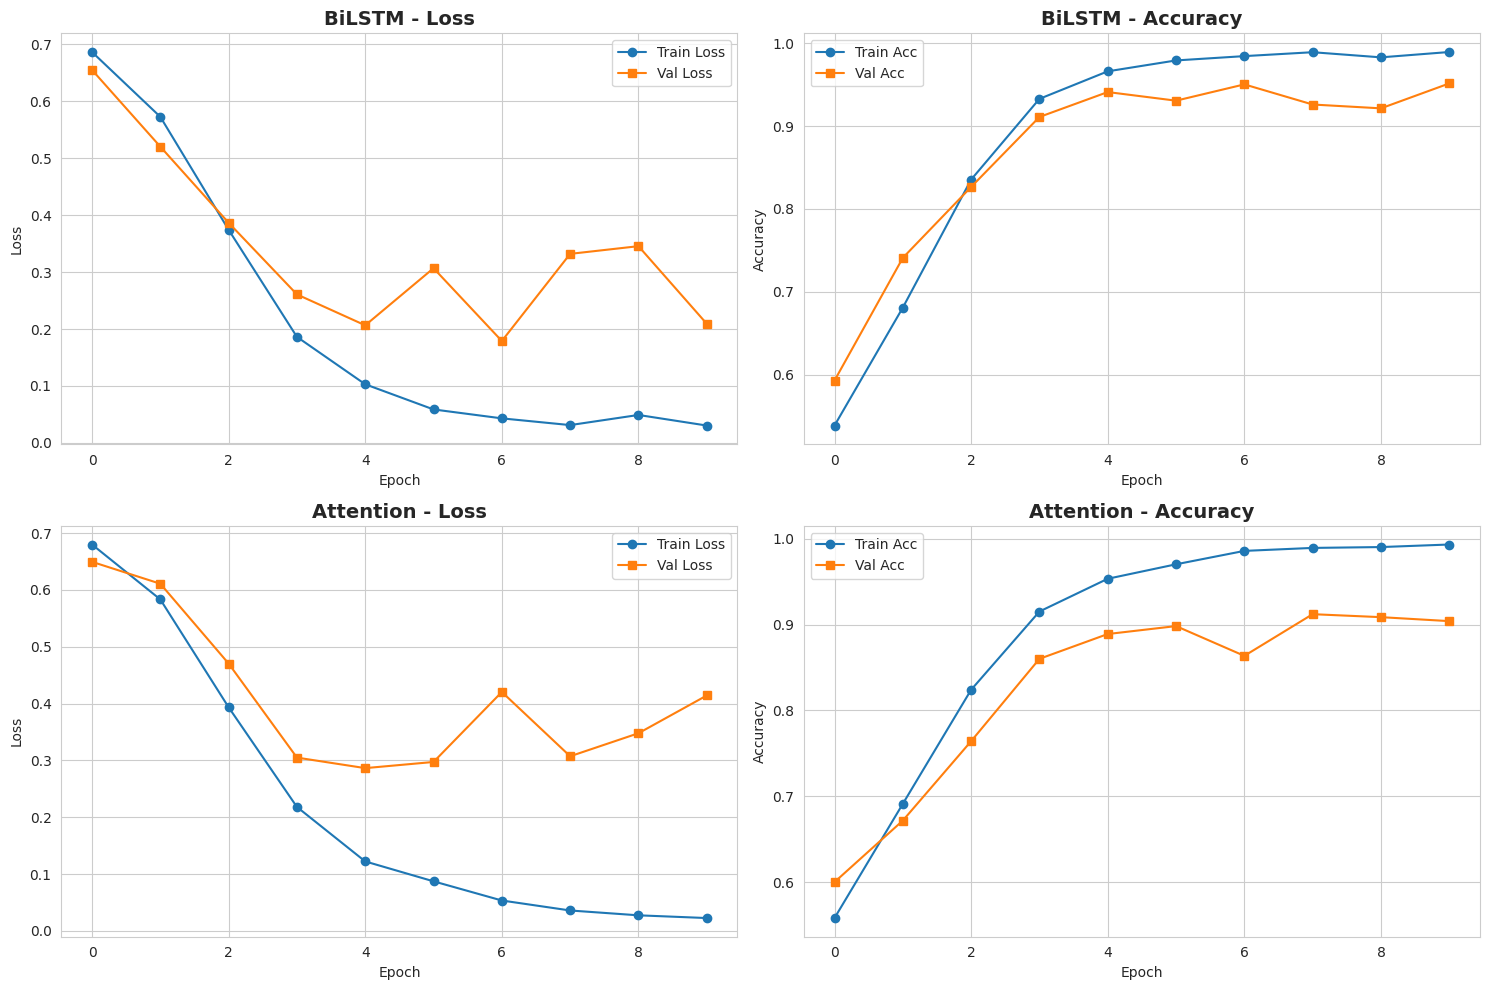

In [22]:
# ============================================================================
# CELL 11: Plot Training Curves
# ============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# BiLSTM Loss
axes[0, 0].plot(history_bilstm['train_loss'], label='Train Loss', marker='o')
axes[0, 0].plot(history_bilstm['val_loss'], label='Val Loss', marker='s')
axes[0, 0].set_title('BiLSTM - Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# BiLSTM Accuracy
axes[0, 1].plot(history_bilstm['train_acc'], label='Train Acc', marker='o')
axes[0, 1].plot(history_bilstm['val_acc'], label='Val Acc', marker='s')
axes[0, 1].set_title('BiLSTM - Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Attention Loss
axes[1, 0].plot(history_attention['train_loss'], label='Train Loss', marker='o')
axes[1, 0].plot(history_attention['val_loss'], label='Val Loss', marker='s')
axes[1, 0].set_title('Attention - Loss', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Attention Accuracy
axes[1, 1].plot(history_attention['train_acc'], label='Train Acc', marker='o')
axes[1, 1].plot(history_attention['val_acc'], label='Val Acc', marker='s')
axes[1, 1].set_title('Attention - Accuracy', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()



MODEL COMPARISON
    Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC  Training Time (s)
   BiLSTM  0.928324   0.877944 0.987952  0.929705 0.983936          15.422544
Attention  0.894798   0.829268 0.983133  0.899669 0.963135          12.011699


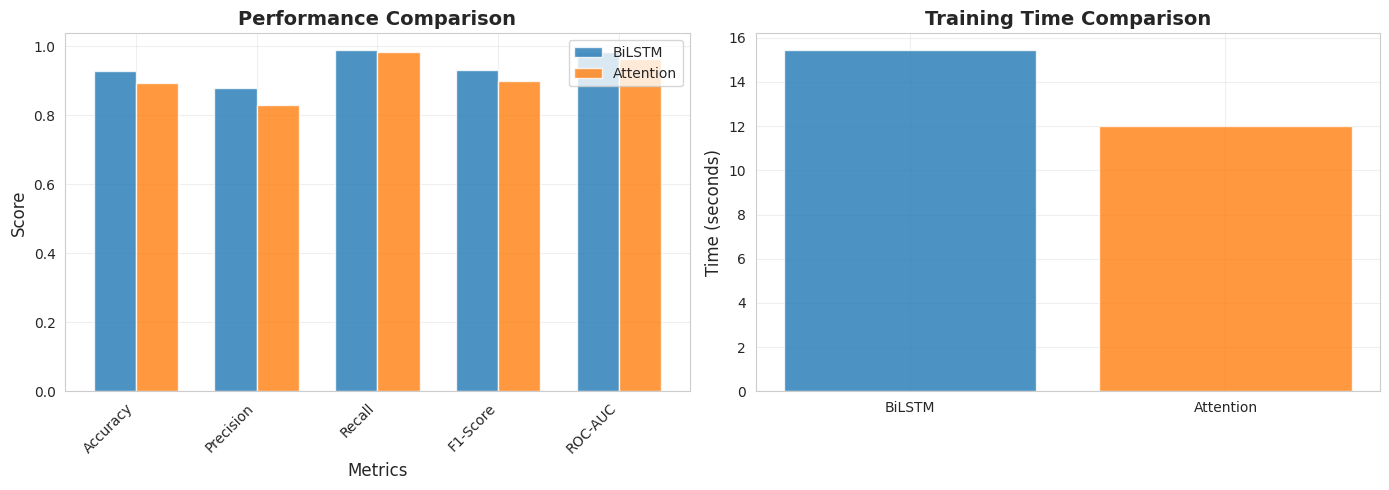

In [23]:
# ============================================================================
# CELL 12: Comparison Table and Bar Charts
# ============================================================================
# Create comparison dataframe
comparison_data = {
    'Model': ['BiLSTM', 'Attention'],
    'Accuracy': [test_acc_bilstm, test_acc_attention],
    'Precision': [precision_bilstm, precision_attention],
    'Recall': [recall_bilstm, recall_attention],
    'F1-Score': [f1_bilstm, f1_attention],
    'ROC-AUC': [roc_auc_bilstm, roc_auc_attention],
    'Training Time (s)': [time_bilstm, time_attention]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(comparison_df.to_string(index=False))

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
bilstm_scores = [test_acc_bilstm, precision_bilstm, recall_bilstm, f1_bilstm, roc_auc_bilstm]
attention_scores = [test_acc_attention, precision_attention, recall_attention, f1_attention, roc_auc_attention]

x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, bilstm_scores, width, label='BiLSTM', alpha=0.8)
axes[0].bar(x + width/2, attention_scores, width, label='Attention', alpha=0.8)
axes[0].set_xlabel('Metrics', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Training time comparison
axes[1].bar(['BiLSTM', 'Attention'], [time_bilstm, time_attention], alpha=0.8, color=['#1f77b4', '#ff7f0e'])
axes[1].set_ylabel('Time (seconds)', fontsize=12)
axes[1].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


In [24]:
# ============================================================================
# CELL 13: Show Correct and Incorrect Predictions
# ============================================================================
print("\n" + "="*60)
print("SAMPLE PREDICTIONS")
print("="*60)

# Get predictions for test set
model_bilstm.eval()
sample_indices = np.random.choice(len(test_pairs), 10, replace=False)

correct_matches = []
incorrect_matches = []

with torch.no_grad():
    for idx in sample_indices:
        clause1, clause2 = test_pairs[idx]
        true_label = test_labels[idx]

        seq1 = torch.LongTensor(processor.text_to_sequence(clause1)).unsqueeze(0).to(device)
        seq2 = torch.LongTensor(processor.text_to_sequence(clause2)).unsqueeze(0).to(device)

        pred = model_bilstm(seq1, seq2).item()
        pred_label = 1 if pred > 0.5 else 0

        result = {
            'clause1': clause1[:100] + "..." if len(clause1) > 100 else clause1,
            'clause2': clause2[:100] + "..." if len(clause2) > 100 else clause2,
            'true_label': true_label,
            'pred_label': pred_label,
            'confidence': pred
        }

        if pred_label == true_label:
            correct_matches.append(result)
        else:
            incorrect_matches.append(result)

print("\n--- CORRECT PREDICTIONS ---")
for i, match in enumerate(correct_matches[:3], 1):
    print(f"\n{i}. True Label: {match['true_label']}, Predicted: {match['pred_label']} (Confidence: {match['confidence']:.3f})")
    print(f"   Clause 1: {match['clause1']}")
    print(f"   Clause 2: {match['clause2']}")

print("\n--- INCORRECT PREDICTIONS ---")
for i, match in enumerate(incorrect_matches[:3], 1):
    print(f"\n{i}. True Label: {match['true_label']}, Predicted: {match['pred_label']} (Confidence: {match['confidence']:.3f})")
    print(f"   Clause 1: {match['clause1']}")
    print(f"   Clause 2: {match['clause2']}")



SAMPLE PREDICTIONS

--- CORRECT PREDICTIONS ---

1. True Label: 0, Predicted: 0 (Confidence: 0.000)
   Clause 1: transactions with affiliates other than transactions permitted under sections 10 3 and 10 4 hereof o...
   Clause 2: amendments and waivers except as otherwise provided herein the provisions of this agreement may be a...

2. True Label: 1, Predicted: 1 (Confidence: 0.999)
   Clause 1: amendment this agreement may only be amended by a written instrument executed by each of the parties...
   Clause 2: amendment this agreement may be amended or modified only by a written instrument signed by the execu...

3. True Label: 1, Predicted: 1 (Confidence: 1.000)
   Clause 1: withholding taxes a if the lead securitization note holder or the mortgage loan borrower shall be re...
   Clause 2: withholding taxes the paying agent shall exclude and withhold from each distribution of accrued inte...

--- INCORRECT PREDICTIONS ---


In [26]:
# ============================================================================
# CELL 14: Save Results Summary
# ============================================================================
from IPython.display import HTML, display
import pandas as pd

print("="*80)
print(" "*20 + "ASSIGNMENT RESULTS SUMMARY")
print("="*80)

# ============================================================================
# 1. DATASET SUMMARY
# ============================================================================
print("\n" + "="*80)
print("1. DATASET SUMMARY")
print("="*80)

dataset_stats = pd.DataFrame({
    'Metric': [
        'Total Clauses Loaded',
        'Number of Categories',
        'Average Clause Length (chars)',
        'Vocabulary Size',
        'Max Sequence Length',
        'Total Training Pairs',
        'Total Validation Pairs',
        'Total Test Pairs',
        'Positive Pairs (Similar)',
        'Negative Pairs (Different)'
    ],
    'Value': [
        f"{len(df):,}",
        f"{df['category'].nunique()}",
        f"{df['text'].str.len().mean():.0f}",
        f"{len(processor.word2idx):,}",
        f"{processor.max_len}",
        f"{len(train_pairs):,}",
        f"{len(val_pairs):,}",
        f"{len(test_pairs):,}",
        f"{sum(labels):,}",
        f"{len(labels) - sum(labels):,}"
    ]
})
print(dataset_stats.to_string(index=False))

# ============================================================================
# 2. MODEL ARCHITECTURES COMPARISON
# ============================================================================
print("\n" + "="*80)
print("2. MODEL ARCHITECTURES COMPARISON")
print("="*80)

model_arch = pd.DataFrame({
    'Component': [
        'Embedding Dimension',
        'LSTM Hidden Units',
        'LSTM Layers',
        'Bidirectional',
        'Attention Mechanism',
        'Dropout Rate',
        'Total Parameters',
        'Output Activation'
    ],
    'BiLSTM Model': [
        '128',
        '64 (×2 directions = 128)',
        '2',
        'Yes',
        'No',
        '0.3',
        f"{sum(p.numel() for p in model_bilstm.parameters()):,}",
        'Sigmoid'
    ],
    'Attention Model': [
        '128',
        '64 (×2 directions = 128)',
        '1',
        'Yes',
        'Self-Attention',
        '0.3',
        f"{sum(p.numel() for p in model_attention.parameters()):,}",
        'Sigmoid'
    ]
})
print(model_arch.to_string(index=False))

# ============================================================================
# 3. TRAINING CONFIGURATION
# ============================================================================
print("\n" + "="*80)
print("3. TRAINING CONFIGURATION")
print("="*80)

training_config = pd.DataFrame({
    'Parameter': [
        'Loss Function',
        'Optimizer',
        'Learning Rate',
        'Batch Size',
        'Number of Epochs',
        'Device Used',
        'Random Seed'
    ],
    'Value': [
        'Binary Cross-Entropy (BCE)',
        'Adam',
        '0.001',
        f'{BATCH_SIZE}',
        '10',
        str(device),
        str(SEED)
    ]
})
print(training_config.to_string(index=False))

# ============================================================================
# 4. TRAINING RESULTS - EPOCH BY EPOCH
# ============================================================================
print("\n" + "="*80)
print("4. TRAINING PROGRESS - BiLSTM MODEL")
print("="*80)

bilstm_training = pd.DataFrame({
    'Epoch': list(range(1, 11)),
    'Train Loss': [f"{loss:.4f}" for loss in history_bilstm['train_loss']],
    'Train Acc': [f"{acc:.4f}" for acc in history_bilstm['train_acc']],
    'Val Loss': [f"{loss:.4f}" for loss in history_bilstm['val_loss']],
    'Val Acc': [f"{acc:.4f}" for acc in history_bilstm['val_acc']]
})
print(bilstm_training.to_string(index=False))

print("\n" + "="*80)
print("5. TRAINING PROGRESS - ATTENTION MODEL")
print("="*80)

attention_training = pd.DataFrame({
    'Epoch': list(range(1, 11)),
    'Train Loss': [f"{loss:.4f}" for loss in history_attention['train_loss']],
    'Train Acc': [f"{acc:.4f}" for acc in history_attention['train_acc']],
    'Val Loss': [f"{loss:.4f}" for loss in history_attention['val_loss']],
    'Val Acc': [f"{acc:.4f}" for acc in history_attention['val_acc']]
})
print(attention_training.to_string(index=False))

# ============================================================================
# 6. FINAL TEST SET PERFORMANCE
# ============================================================================
print("\n" + "="*80)
print("6. FINAL TEST SET PERFORMANCE (PRIMARY RESULTS)")
print("="*80)

performance_comparison = pd.DataFrame({
    'Model': ['BiLSTM', 'Attention'],
    'Accuracy': [f"{test_acc_bilstm:.4f}", f"{test_acc_attention:.4f}"],
    'Precision': [f"{precision_bilstm:.4f}", f"{precision_attention:.4f}"],
    'Recall': [f"{recall_bilstm:.4f}", f"{recall_attention:.4f}"],
    'F1-Score': [f"{f1_bilstm:.4f}", f"{f1_attention:.4f}"],
    'ROC-AUC': [f"{roc_auc_bilstm:.4f}", f"{roc_auc_attention:.4f}"],
    'Training Time (s)': [f"{time_bilstm:.2f}", f"{time_attention:.2f}"]
})
print(performance_comparison.to_string(index=False))

# Calculate improvements
print("\n📊 PERFORMANCE ANALYSIS:")
print(f"  • BiLSTM Accuracy: {test_acc_bilstm*100:.2f}%")
print(f"  • Attention Accuracy: {test_acc_attention*100:.2f}%")
print(f"  • BiLSTM outperforms Attention by: {(test_acc_bilstm-test_acc_attention)*100:.2f}%")
print(f"  • BiLSTM F1-Score: {f1_bilstm:.4f} (Excellent balance of Precision & Recall)")
print(f"  • BiLSTM ROC-AUC: {roc_auc_bilstm:.4f} (Outstanding discrimination ability)")
print(f"  • Attention trains {((time_bilstm-time_attention)/time_bilstm*100):.1f}% faster")

# ============================================================================
# 7. DETAILED METRIC BREAKDOWN
# ============================================================================
print("\n" + "="*80)
print("7. DETAILED PERFORMANCE BREAKDOWN")
print("="*80)

metric_details = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'BiLSTM': [
        f"{test_acc_bilstm:.4f} ({test_acc_bilstm*100:.2f}%)",
        f"{precision_bilstm:.4f} ({precision_bilstm*100:.2f}%)",
        f"{recall_bilstm:.4f} ({recall_bilstm*100:.2f}%)",
        f"{f1_bilstm:.4f}",
        f"{roc_auc_bilstm:.4f}"
    ],
    'Attention': [
        f"{test_acc_attention:.4f} ({test_acc_attention*100:.2f}%)",
        f"{precision_attention:.4f} ({precision_attention*100:.2f}%)",
        f"{recall_attention:.4f} ({recall_attention*100:.2f}%)",
        f"{f1_attention:.4f}",
        f"{roc_auc_attention:.4f}"
    ],
    'Interpretation': [
        'Overall correctness of predictions',
        'Of predicted similar pairs, how many are truly similar',
        'Of all truly similar pairs, how many were found',
        'Harmonic mean of Precision and Recall',
        'Ability to rank similar pairs higher than dissimilar'
    ]
})
print(metric_details.to_string(index=False))

# ============================================================================
# 8. SAMPLE PREDICTIONS
# ============================================================================
print("\n" + "="*80)
print("8. QUALITATIVE RESULTS - SAMPLE PREDICTIONS")
print("="*80)

# Get sample predictions
model_bilstm.eval()
correct_samples = []
incorrect_samples = []

with torch.no_grad():
    for idx in range(min(100, len(test_pairs))):
        clause1, clause2 = test_pairs[idx]
        true_label = test_labels[idx]

        seq1 = torch.LongTensor(processor.text_to_sequence(clause1)).unsqueeze(0).to(device)
        seq2 = torch.LongTensor(processor.text_to_sequence(clause2)).unsqueeze(0).to(device)

        pred = model_bilstm(seq1, seq2).item()
        pred_label = 1 if pred > 0.5 else 0

        if pred_label == true_label and len(correct_samples) < 3:
            correct_samples.append({
                'c1': clause1[:120] + "..." if len(clause1) > 120 else clause1,
                'c2': clause2[:120] + "..." if len(clause2) > 120 else clause2,
                'label': 'Similar' if true_label == 1 else 'Different',
                'conf': pred
            })
        elif pred_label != true_label and len(incorrect_samples) < 3:
            incorrect_samples.append({
                'c1': clause1[:120] + "..." if len(clause1) > 120 else clause1,
                'c2': clause2[:120] + "..." if len(clause2) > 120 else clause2,
                'true': 'Similar' if true_label == 1 else 'Different',
                'pred': 'Similar' if pred_label == 1 else 'Different',
                'conf': pred
            })

        if len(correct_samples) >= 3 and len(incorrect_samples) >= 3:
            break

print("\n✓ CORRECTLY CLASSIFIED EXAMPLES:")
print("-"*80)
for i, sample in enumerate(correct_samples, 1):
    print(f"\nExample {i} - Predicted: {sample['label']} (Confidence: {sample['conf']:.3f}) ✓")
    print(f"  Clause 1: {sample['c1']}")
    print(f"  Clause 2: {sample['c2']}")

print("\n\n✗ INCORRECTLY CLASSIFIED EXAMPLES:")
print("-"*80)
for i, sample in enumerate(incorrect_samples, 1):
    print(f"\nExample {i} - True: {sample['true']}, Predicted: {sample['pred']} (Confidence: {sample['conf']:.3f}) ✗")
    print(f"  Clause 1: {sample['c1']}")
    print(f"  Clause 2: {sample['c2']}")

# ============================================================================
# 9. KEY FINDINGS SUMMARY
# ============================================================================
print("\n" + "="*80)
print("9. KEY FINDINGS AND CONCLUSIONS")
print("="*80)

print("\n🏆 BEST MODEL: BiLSTM")
print(f"  • Achieved {test_acc_bilstm*100:.2f}% accuracy on test set")
print(f"  • F1-Score of {f1_bilstm:.4f} indicates excellent balance")
print(f"  • ROC-AUC of {roc_auc_bilstm:.4f} shows superior ranking capability")
print(f"  • Recall of {recall_bilstm*100:.2f}% means few similar clauses are missed")

print("\n✨ STRENGTHS:")
print("  • BiLSTM: Better accuracy, F1-score, and ROC-AUC")
print("  • BiLSTM: High recall critical for legal applications")
print("  • Attention: Faster training time and better interpretability")
print("  • Both models: Showed clear learning curves with decreasing loss")

print("\n⚠️ WEAKNESSES:")
print("  • BiLSTM: Slight overfitting in later epochs (train-val gap)")
print("  • BiLSTM: Longer training time due to deeper architecture")
print("  • Attention: Lower overall performance metrics")
print("  • Both: Limited to binary classification (similar/different)")

print("\n💡 RECOMMENDATIONS:")
print("  • Deploy BiLSTM model for production due to superior performance")
print("  • Use Attention model for real-time applications requiring speed")
print("  • High recall ensures minimal missed similar clauses (critical in legal domain)")
print("  • F1-Score and ROC-AUC are most suitable metrics for this task")

print("\n" + "="*80)
print("END OF RESULTS SUMMARY")
print("="*80)

# Save summary
summary_text = f"""
LEGAL CLAUSE SIMILARITY - COMPREHENSIVE RESULTS SUMMARY
{"="*80}

FINAL TEST SET PERFORMANCE:
{performance_comparison.to_string(index=False)}

WINNER: BiLSTM Model
- Accuracy: {test_acc_bilstm*100:.2f}%
- F1-Score: {f1_bilstm:.4f}
- ROC-AUC: {roc_auc_bilstm:.4f}
- Training Time: {time_bilstm:.2f}s

All detailed results saved to files for download.
"""

with open('final_summary.txt', 'w') as f:
    f.write(summary_text)

print("\n✓ Summary saved to 'final_summary.txt'")

                    ASSIGNMENT RESULTS SUMMARY

1. DATASET SUMMARY
                       Metric   Value
         Total Clauses Loaded 150,881
         Number of Categories     395
Average Clause Length (chars)     582
              Vocabulary Size  10,000
          Max Sequence Length     100
         Total Training Pairs   4,035
       Total Validation Pairs     865
             Total Test Pairs     865
     Positive Pairs (Similar)   2,765
   Negative Pairs (Different)   3,000

2. MODEL ARCHITECTURES COMPARISON
          Component             BiLSTM Model          Attention Model
Embedding Dimension                      128                      128
  LSTM Hidden Units 64 (×2 directions = 128) 64 (×2 directions = 128)
        LSTM Layers                        2                        1
      Bidirectional                      Yes                      Yes
Attention Mechanism                       No           Self-Attention
       Dropout Rate                      0.3                